In [1]:
!pip install -q efficientnet
import pandas as pd
import numpy as np
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import re
import tensorflow.keras.applications.efficientnet as eff
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
from sklearn import metrics
import gc
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from matplotlib import pyplot as plt
%matplotlib inline

2021-12-05 14:00:20.335469: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-05 14:00:20.335584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-05 14:00:26.330994: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 14:00:26.333955: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-05 14:00:26.333992: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-05 14:00:26.334023: I tensorflow/stream_executor/cuda/cud

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-12-05 14:00:27.508547: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-05 14:00:27.508629: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-12-05 14:00:27.533239: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-05 14:00:27.533294: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-12-05 14:00:27.533850: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8


In [3]:
# Configuration
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 15
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]
# Seed
SEED = 9527
seed = 9527
# Learning rate
LR = 0.0005
# Verbosity
VERBOSE = 2
# Label_dim
label_dim = 35

# dataset path

img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
VOCAB_SIZE = 1871
TITLE_EMBEDDING_SIZE = 50

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(input1, label):
#     print(len(image), image)
    image = input1["inp1"]
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return {"inp1": image, "inp2": tf.expand_dims(input1["inp2"], -1)}, label

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
        "title": tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
        "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    title = example['title']
    label = example['cleaned_ingredients']

    
    return  {"inp1": image, "inp2": title}, label

def load_dataset(filenames, target, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, target, ordered = False):
    dataset = load_dataset(filenames, target, ordered = ordered)
    
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, target, ordered = True):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [5]:
train_dataset = get_training_dataset(train_set, TARGET, ordered = False)

In [6]:
for fo in train_dataset.take(1):
    print(fo)

({'inp1': <tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 7.1989417e-01,  7.9102373e-01,  8.1141019e-01],
         [ 7.1025401e-01,  7.8788608e-01,  8.0813062e-01],
         [ 7.0697445e-01,  7.8460652e-01,  8.0485106e-01],
         ...,
         [ 7.4632931e-01,  8.2396138e-01,  8.4420598e-01],
         [ 7.5587022e-01,  8.2056820e-01,  8.4420598e-01],
         [ 7.6233006e-01,  8.2059652e-01,  8.4748554e-01]],

        [[ 7.1661460e-01,  7.8774416e-01,  8.0813062e-01],
         [ 7.0697445e-01,  7.8460652e-01,  8.0485106e-01],
         [ 7.1025401e-01,  7.8788608e-01,  8.0813062e-01],
         ...,
         [ 7.4960887e-01,  8.2724094e-01,  8.4748554e-01],
         [ 7.6242936e-01,  8.2712734e-01,  8.5076511e-01],
         [ 7.6242936e-01,  8.2712734e-01,  8.5076511e-01]],

        [[ 7.0041525e-01,  7.7804732e-01,  7.9829192e-01],
         [ 7.0369482e-01,  7.8132695e-01,  8.0157149e-01],
         [ 7.0697445e-01,  7.8460652e-01,  8.0485106e-01],
         ...,


In [7]:
val_dataset = get_validation_dataset(val_set, TARGET, ordered = True)

2021-12-05 14:00:36.456572: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 34, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638712836.452729175","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 34, Output num: 2","grpc_status":3}


In [8]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()


In [9]:
def get_lr_callback():
    # lr_start   = 0.0000001
    # lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.0000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < EPOCHS/2:
            lr = 0.000001 * (BATCH_SIZE - epoch)
        else:
            lr = lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [10]:
def get_model(mode):

    with strategy.scope():

        inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
        inp2 = tf.keras.layers.Input(shape = (TITLE_EMBEDDING_SIZE, 1, ), name='inp2')
        print(f'load Model_{mode}')
        y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(inp2)
#         y = tf.keras.layers.Reshape((50, 1))(inp2)
        y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(y)
        
#         y = tf.keras.layers.Dropout(.3)(y)
        if mode == 'eff0':
            x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff1':
            x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff2':
            x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff3':
            x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff4':
            x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff5':
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff6':
            x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff7':
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV2':
            x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV3':
            x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'XCP':
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG16':
            x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG19':
            x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'RN50':
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
        else:
            # 'RN101'
            x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.add([x, y])
        x = tf.keras.layers.Flatten()(x)
        output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = [inp, inp2], outputs = [output])
        opt = tf.keras.optimizers.Adam(learning_rate = LR)

        model.compile(
            optimizer = opt,
            loss="binary_crossentropy"

            ) 
        print(model.summary())
        return model

In [11]:
def plot_model(mode):
    model = get_model(mode=mode)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_{mode}_{505}.h5', 
                                                        monitor = 'val_loss', 
                                                        verbose = 2, 
                                                        save_best_only = True,
                                                        save_weights_only = True, 
                                                        mode = 'min')
    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, get_lr_callback()], 
                            validation_data = val_dataset,
                            verbose = VERBOSE)
    
    gc.collect()
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [12]:
models = ['eff1','eff2','eff3','eff4','eff5','eff6','eff7','XCP', 'RN50']
# plot_model(models[0]) # 0.02689

In [13]:
# plot_model(models[1]) # 0.02496

In [14]:
# plot_model(models[2]) # 0.02553

In [15]:
# plot_model(models[3]) # 0.02362

In [16]:
# plot_model(models[4]) # 0.02044

In [17]:
# plot_model(models[5]) # 0.01980

In [18]:
# plot_model(models[6]) # 0.01969

In [19]:
# plot_model(models[7]) # 0.01954

load Model_RN50
94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
_____________

2021-12-05 14:02:14.467225: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 28993, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638712934.466668898","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 28993, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.02781, saving model to Model_RN50_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 17s - loss: 0.0200 - val_loss: 0.0233

Epoch 00002: val_loss improved from 0.02781 to 0.02326, saving model to Model_RN50_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 17s - loss: 0.0195 - val_loss: 0.0208

Epoch 00003: val_loss improved from 0.02326 to 0.02076, saving model to Model_RN50_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 17s - loss: 0.0192 - val_loss: 0.0203

Epoch 00004: val_loss improved from 0.02076 to 0.02029, saving model to Model_RN50_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 17s - loss: 0.0189 - val_loss: 0.0202

Epoch 00005: val_loss improved from 0.02029 to 0.02023, saving model to Model_RN50_505.h5
Epoch 6/15

Ep

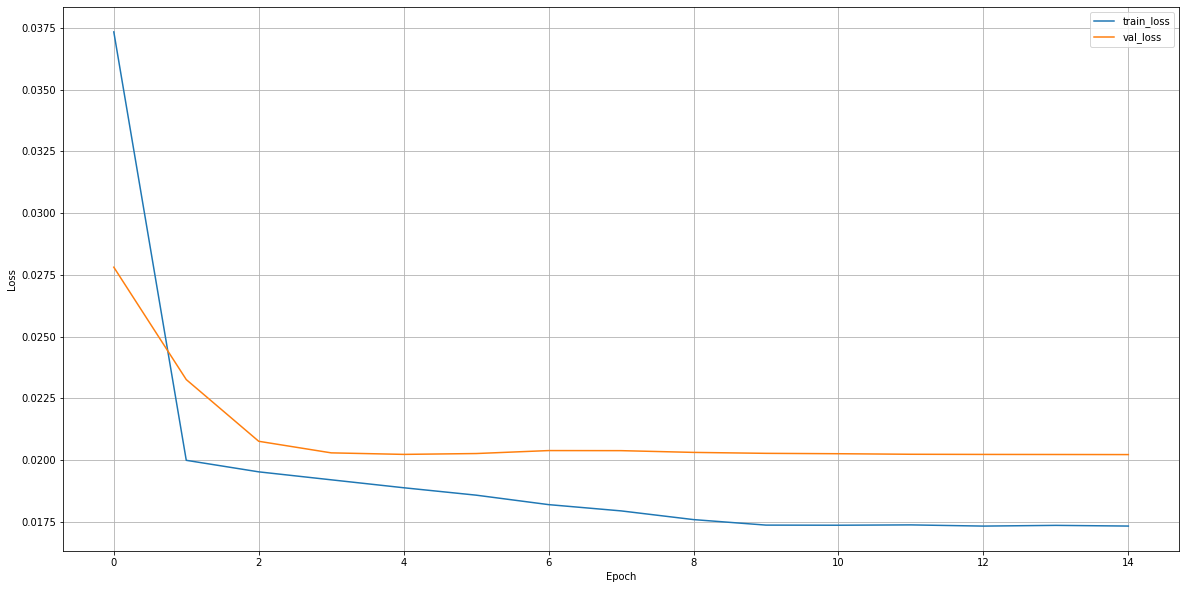

In [20]:
plot_model(models[8])